# Debiasing with Orthogonalization

Previously, we saw how to evaluate a causal model. By itself, that's a huge deed. Causal models estimates the elasticity $\frac{\delta y}{\delta t}$, which is an unseen quantity. Hence, since we can't see the ground truth of what our model is estimating, we had to be very creative in how we would go about evaluating them. 

The technique shown on the previous chapter relied heavily on data where the treatment was randomly assigned. The idea was to estimate the elasticity $\frac{\delta y}{\delta t}$ as the coefficient of a single variable linear regression of `y ~ t`. However, this only works if the treatment is randomly assigned. If it isn't, we get into trouble due to omitted variable bias. 

To workaround this, we need to make the data look as if the treatment is randomly assigned. I would say there are two main techniques to do this. One is using propensity score and the other using orthogonalization. We will cover the latter in this chapter.

One final word of caution before we continue. I would argue that probably the safest way out of non random data is to go out and do some sort of experiment to gather random data. I myself don't trust very much on debiasing techniques because you can never know if you've accounted for every confounder. Having said that, orthogonalization is still very much worth learning. It's an incredibly powerful technique that will be the foundation of many causal models to come. 

## Linear Regression Reborn

The idea of orthogonalization is based on a theorem designed by three econometricians in 1933, Ragnar Frisch, Frederick V. Waugh, and Michael C. Lovell. Simply put, it states that you can decompose any multivariable linear regression model into three stages or models. Let's say that your features are in an $X$ matrix. Now, you partition that matrix in such a way that you get one part, $X_1$, with some of the features and another part, $X_2$, with the rest of the features. 

In the first stage, we take the first set of features and estimate the following linear regression model 

$$
y_i = \theta_0 + \pmb{\theta_1 X}_{1i} + e_i
$$

where $\pmb{\theta_1}$ is a vector of parameters. We then take the residuals of that model

$$
y^* = y_i - (\hat{\theta}_0 + \pmb{\hat{\theta}_1 X}_{1i})
$$

On the second stage, we take the first set of features again, but now we run a model where we estimate the second set of features

$$
\pmb{X}_{2i} = \gamma_0 + \pmb{\gamma_1 X}_{1i} + e_i
$$

Here, we are using the first set of features to predict the second set of features. Finally, we also take the residuals for this second stage.

$$
\pmb{X}^*_{2i} = \pmb{X}_{2i} - (\hat{\gamma}_0 + \pmb{\hat{\gamma}_1 X}_{1i})
$$


Lastly, we take the residuals from the first and second stage, and estimate the following model

$$
y_i^* = \beta_0 + \pmb{\beta_2 X}^*_{2i} + e_i
$$

The Frisch–Waugh–Lovell theorem states that the parameter estimate $\pmb{\hat{\beta}_2}$ from estimating this model is equivalent to the one we get by running the full regression, with all the features:

$$
y_i = \beta_0 + \pmb{\beta_1 X}_{1i} + \pmb{\beta_2 X}_{2i} + e_i
$$

![img](./data/img/orthogonal/nazare-confusa.jpg)

OK. Let's unpack this a bit further. We know that regression is a very special model. Each of its parameters has the interpretation of a partial derivative: how much would $Y$ increase if I increase one feature **while holding all the others fixed**. This is very nice for causal inference, because it means we can control for variables in the analysis, even if those same variables have not been held fixed during the collection of the data.

We also know that if we omit variables from the regression, we get bias. Specifically, omitted variable bias (or confounding bias). Still, the Frisch–Waugh–Lovell is saying that I can break my regression model into two parts, neither of them containing the full feature set, and still get the same estimate I would get by running the entire regression. Not only that, this theorem also provides some insight into what linear regression is doing. To get the coefficient of one variable $X_k$, regression first uses all the other variables to predict $X_k$ and takes the residuals. This "cleans"  $X_k$ of any influence from those variables. That way, when we try to understand $X_k$'s impact on $Y$, it will be free from omitted variable bias. Second, regression uses all the other variables to predict $Y$ and takes the residuals. This "cleans" $Y$ from any influence from those variables, reducing the variance of $Y$ so that it is easier to see how $X_k$ impacts $Y$. 

I know it can be hard to appreciate how awesome this is. But remember what linear regression is doing. It's estimating the impact of $X_2$ on $y$ while accounting for $X_1$. This is incredibly powerful for causal inference. It says that I can build a model that predicts my treatment $t$ using my features $X$, a model that predicts the outcome $y$ using the same features, take the residuals from both models and run a model that estimates how the residual of $t$ affects the residual of $y$. This last model will tell me how $t$ affects $y$ while controlling for $X$. In other words, the first two models are controlling for the confounding variables. They are generating data which is as good as random. This is debiasing my data. That's what we use in the final model to estimate the elasticity.

There is a (not so complicated) mathematical proof for why that is the case, but I think the intuition behind this theorem is so straightforward we can go directly into it.

## The Intuition Behind Orthogonalization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm

from nb21 import cumulative_elast_curve_ci, elast, cumulative_gain_ci

Let's take our price data once again. But now, we will only take the sample where prices where **not** randomly assigned. Once again, we separate them into a training and a test set. Since we will use the test set to evaluate our causal model, let's see how we can use orthogonalization to debias it.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv")

train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

If we show the correlations on the test set, we can see that price is positively correlated with sales, meaning that sales should go up as we increase prices. This is obviously nonsense. People don't buy more if ice cream is expensive. We probably have some sort of bias here. 

In [3]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,-0.020859,0.011054,-0.008858,0.375964
weekday,-0.020859,1.000000,0.007954,-0.013246,0.012259
cost,0.011054,0.007954,1.000000,0.387322,0.002826
price,-0.008858,-0.013246,0.387322,1.000000,0.073626
sales,0.375964,0.012259,0.002826,0.073626,1.000000


If we plot our data, we can see why this is happening. Weekends (Saturday and Sunday) have higher price but also higher sales. We can see that this is the case because the weekend cloud of points seems to be to the upper right part of the plot.

Weekend is probably playing an important role in the bias here. On the weekends, there are more ice cream sales because there is more demand. In response to that demand, prices go up. So it is not that the increase in price causes sales to go up. It is just that both sales and prices are high on weekends. 

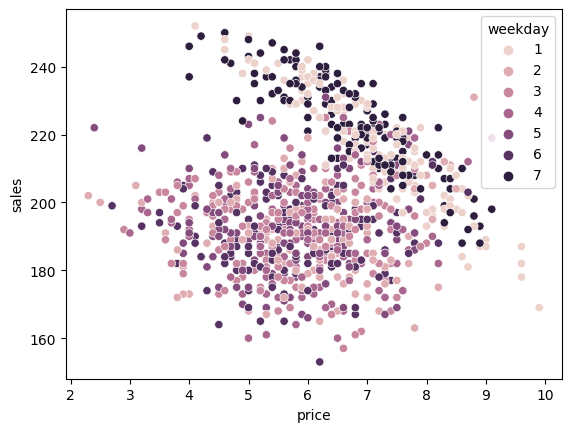

In [4]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

To debias this dataset we will need two models. The first model, let's call it $M_t(X)$, predicts the treatment (price, in our case) using the confounders. It's the one of the stages we've seen above, on the Frisch–Waugh–Lovell theorem.

In [5]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

Once we have this model, we will construct the residuals

$$
\hat{t}_i = t_i - M_t(X_i)
$$

You can think of this residual as a version of the treatment that is unbiased or, better yet, that is impossible to predict from the confounders $X$. Since the confounders were already used to predict $t$, the residual is by definition, unpredictable with $X$. Another way of saying this is that the bias has been explained away by the model $M_t(X_i)$, producing $\hat{t}_i$ which is as good as randomly assigned. Of course this only works if we have in $X$ all the confounders that cause both $T$ and $Y$.

We can also plot this data to see what it looks like.

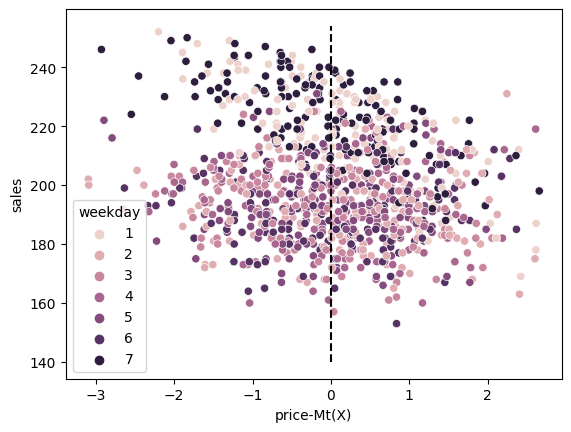

In [6]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles='--', color="black");

We can see that the weekends are no longer to the upper right corner. They got pushed to the center. Moreover, we can no longer differentiate between different price levels (the treatment) using the weekdays. We can say that the residual $price-M_t(X)$, plotted on the x-axis, is a "random" or debiased version of the original treatment.

This alone is sufficient to debias the dataset. This new treatment we've created is as good as randomly assigned. But we can still do one other thing to make the debiased dataset even better. Namely, we can also construct residuals for the outcome.

$$
\hat{y}_i = y_i - M_y(X_i)
$$

This is another stage from the Frisch–Waugh–Lovell theorem. It doesn't make the set less biased, but it makes it easier to estimate the elasticity by reducing the variance in $y$. Once again, you can think about $\hat{y}_i$ as a version of $y_i$ that is unpredictable from $X$ or that had all its variances due to $X$ explained away. Think about it. We've already used $X$ to predict $y$ with $M_y(X_i)$. And $\hat{y}_i$ is the error of this prediction. So, by definition, it's not possible to predict it from $X$. All the information in $X$ to predict $y$ has already been used. If that is the case, the only thing left to explain $\hat{y}_i$ is something we didn't used to construct it (not included in $X$), which is only the treatment (again, assuming no unmeasured confounders). 

In [7]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

Once we do both transformations, not only does weekdays not predict the price residuals, but it also can't predict the residual of sales $\hat{y}$. The only thing left to predict these residuals is the treatment. Also, notice something interesting. In the plot above, it was hard to know the direction of the price elasticity. It looked like sales decreased as prices went up, but there was such a large variance in sales that it was hard to say that for sure. 

Now, when we plot the two residuals, it becomes much clear that sales indeed causes prices to go down.

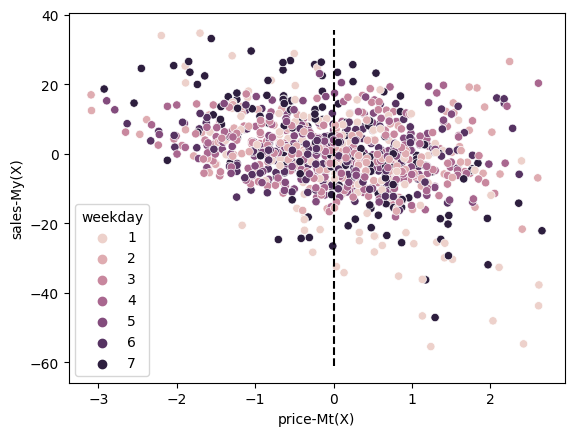

In [8]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles='--', color="black");

One small disadvantage of this debiased data is that the residuals have been shifted to a different scale. As a result, it's hard to interpret what they mean (what is a price residual of -3?). Still, I think this is a small price to pay for the convenience of building random data from data that was not initially random. 

To summarize, by predicting the treatment, we've constructed $\hat{t}$ which works as an unbiased version of the treatment; by predicting the outcome, we've constructed $\hat{y}$ which is a version of the outcome that can only be further explained if we use the treatment. This data, where we replace $y$ by $\hat{y}$ and $t$ by $\hat{t}$ is the debiased data we wanted. We can use it to evaluate our causal model just like we deed previously using random data.

To see this, let's once again build a causal model for price elasticity using the training data.

In [9]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

Then, we'll make elasticity predictions on the debiased test set.

In [10]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
4200,20.7,2,1.0,6.9,180,0.813092,-5.058538,0.689368
9117,30.5,4,1.0,5.4,216,-0.586101,11.724688,-3.094658
5167,33.0,3,0.3,6.0,209,0.674371,0.337053,-2.424438
1727,23.1,1,1.5,7.7,204,0.216009,-15.212492,-14.464152
7318,28.6,4,0.3,3.3,201,-1.997946,-0.111477,-1.006292


Now, when it comes to plotting the cumulative elasticity, we still order the dataset by the predictive elasticity, but now we use the debiased versions of the treatment and outcome to get this elasticity. This is equivalent to estimating $\beta_1$ in the following regression model

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

where the residuals are like we've described before.

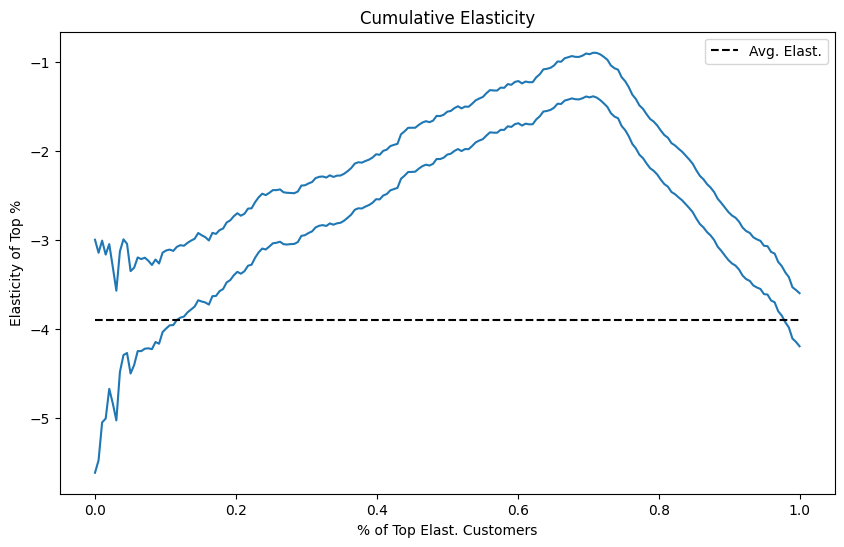

In [11]:
plt.figure(figsize=(10,6))

cumm_elast = cumulative_elast_curve_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_elast)))
plt.plot(x/x.max(), cumm_elast, color="C0")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cumulative Elasticity")
plt.legend();

We can do the same thing for the cumulative gain curve, of course.

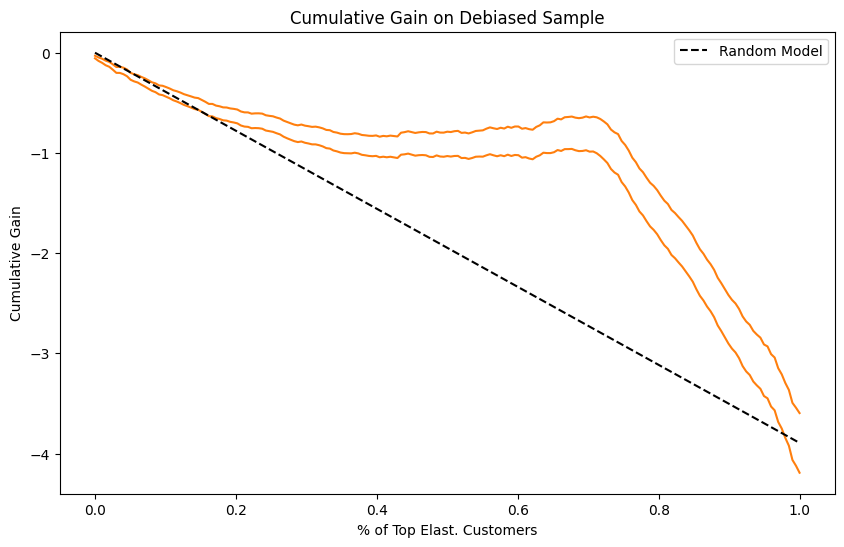

In [12]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain on Debiased Sample")
plt.legend();

Notice how similar these plots are to the ones in the previous chapter. This is some indication that the debiasing worked wonders here. 

In contrast, let's see what the cumulative gain plot would look like if we used the original, biased data.

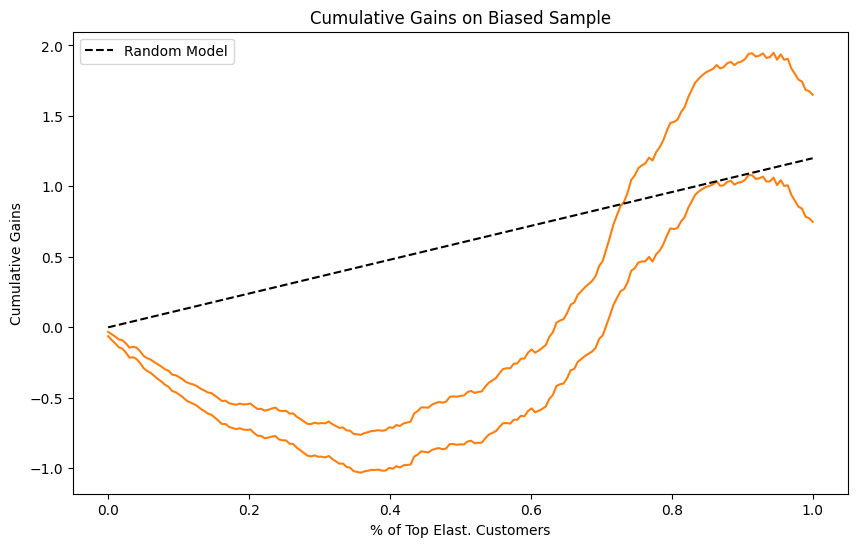

In [13]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.title("Cumulative Gains on Biased Sample")
plt.ylabel("Cumulative Gains")
plt.legend();

First thing you should notice is that the average elasticity goes up, instead of down. We've seen this before. In the biased data, it looks like sales goes up as price increases. As a result, the final point in the cumulative gain plot is positive. This makes little sense, since we now people don't buy more as we increase ice cream prices. If the average price elasticity is already messed up, any ordering in it also makes little sense. The bottom line being that this data should not be used for model evaluation.

## Orthogonalization with Machine Learning

In a 2016 paper, Victor Chernozhukov *et all* showed that you can also do orthogonalization with machine learning models. This is obviously very recent science and we still have much to discover on what we can and can't do with ML models. Still, it's a very interesting idea to know about.

The nuts and bolts are pretty much the same to what we've already covered. The only difference is that now, we use machine learning models for the debiasing. 

$$
\begin{align}
\hat{y}_i &= y_i - M_y(X_i) \\
\hat{t}_i &= t_i - M_t(X_i)
\end{align}
$$

There is a catch, though. As we know very well, machine learning models are so powerful that they can fit the data perfectly, or rather, overfit. Just by looking at the equations above, we can know what will happen in that case. If $M_y$ somehow overfits, the residuals will all be very close to zero. If that happens, it will be hard to find how $t$ affects it. Similarly, if $M_t$ somehow overfits, its residuals will also be close to zero. Hence, there won't be variation in the treatment residual to see how it can impact the outcome. 

To account for that, we need to do sample splitting. That is, we estimate the model with one part of the dataset and we make predictions in the other part. The simplest way to do this is to split the test sample in half, make two models  in such a way that each one is estimated in one half of the dataset and makes predictions in the other half. 

A slightly more elegant implementation uses K-fold cross validation. The advantage being that we can train all the models on a sample which is bigger than half the test set.

![img](./data/img/orthogonal/kfold-cv.png)

Fortunately, this sort of cross prediction is very easy to implement using Sklearn's `cross_val_predict` function.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

X = ["cost", "weekday", "temp"]
t = "price"
y = "sales"

folds = 5

np.random.seed(123)
m_t = RandomForestRegressor(n_estimators=100)
t_res = test[t] - cross_val_predict(m_t, test[X], test[t], cv=folds)

m_y = RandomForestRegressor(n_estimators=100)
y_res = test[y] - cross_val_predict(m_y, test[X], test[y], cv=folds)

Now that we have the residuals, let's store them as columns on a new dataset. 

In [15]:
ml_debiased_test = test.assign(**{
    "sales-ML_y(X)": y_res,
    "price-ML_t(X)": t_res,
})
ml_debiased_test.head()

,temp,weekday,cost,price,sales,sales-ML_y(X),price-ML_t(X)
4200,20.7,2,1.0,6.9,180,-7.769500,1.835250
9117,30.5,4,1.0,5.4,216,7.472024,0.239715
5167,33.0,3,0.3,6.0,209,-1.448000,1.050167
1727,23.1,1,1.5,7.7,204,3.228500,0.334276
7318,28.6,4,0.3,3.3,201,-4.067500,-0.840100


Finally, we can plot the debiased dataset. 

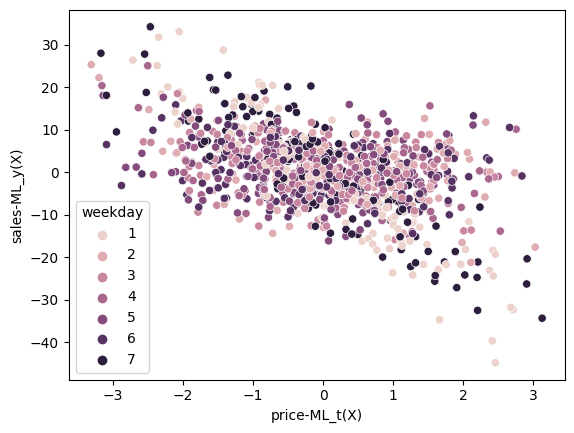

In [16]:
np.random.seed(123)
sns.scatterplot(data=ml_debiased_test.sample(1000),
                x="price-ML_t(X)", y="sales-ML_y(X)", hue="weekday");

Once again, we've uncovered a negative price elasticity on sales. Actually, the plot is incredibly similar to the one we've got when using simple linear regression. But that's probably because this is a very simple dataset. The advantages of machine learning orthogonalization is that it can estimate more complicated functions. It can learn interactions and non linearities in a way that it's hard to encode into linear regression. Also, there is the advantage that some machine learning models (those bases on decision trees) are much simpler to run than linear regression. They can handle categorical data, outliers and even missing data, stuff that would require some attention if you are just using linear regression. 

Finally, before we close, I just need to cover one final common mistake that data scientists often make when they are introduced to this idea (been there, done that). If the treatment or the outcome is binary, one might think it is better to replace the machine learning regression models for their classification versions. However, this does not work. The theory of orthogonalization only functions under regression models, similarly with what we've seen a long time ago when talking about Instrumental Variables. To be honest, it is not that the model will fail miserably if you replace regression by classification, but I would advise against it. If the theory doesn't justify it, why run the risk? 

## Key Ideas

We've started the chapter by highlighting the necessity of random treatment assignment in order for our causal evaluation methods to work. This poses a problem in the case where random data is not available. To be clear, the safest solution in this case is to go and do some experiments in order to get random data. If that is out of the question, only then, we can rely on a clever alternative: transform our data to look as if the treatment has been randomly assigned. 

Here, we've covered how to do that using the principles of orthogonalization. First, we've built a model that uses our features $X$ to predict the treatment $t$ and get it's residuals. The idea being that the treatment residuals is, by definition, independent of the features used to construct it. In other words, the treatment residuals are orthogonal to the features. We can see these residuals as a version of the treatment where all the confounding bias due to $X$ has been removed. 

That alone is enough to make our data look as good as random. But we can go one step further. We can build a model that predicts the outcome $y$ using the features $X$ but not the treatment and also get its residuals. Again, the intuition is very similar. These outcome residuals is a version of the outcome where all the variance due to the features has been explained away. That will hopefully explay a lot of the variance, making it easier to see the treatment effect.

Here we are using orthogonalization with the goal of debiasing our data for model evaluation. However, this technique is also used for other purposes. Namely, lot's of causal inference models use orthogonalization as a first pre-processing step to ease the task of the causal inference model. We can say that orthogonalization makes the foundation of many modern causal inference algorithms.

![img](./data/img/orthogonal/athlas.png)


## References 

The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.

This chapter is based on Victor Chernozhukov *et all* (2016), Double/Debiased Machine Learning for Treatment and Causal Parameters. You can also check Frisch, Ragnar; Waugh, Frederick V. (1933) original article, Partial Time Regressions as Compared with Individual Trends. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).